In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

# <span style="color:red">ch8_트랜스포머(영화평감상분석)</span>


- imdb사이트의 5만개 영화평 : Train/test - 타겟변수 :  부정/긍정

# 1. 패키지 import


In [2]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from time import time # 유닉스time을 계산하기 위해

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

# 2. 하이퍼파라미터 설정

- 하이퍼파라미터를 바꾸면 모델의 정확도나 속도에 차이남


In [7]:
MY_WORDS = 20000 # imdb 데이터 안의 단어 수
MY_LENGTH = 200   # 독립변수 차원(영화평 평균길이 정도)
MY_EMBED  = 32   # Embedding 결과 차원
MY_HIDDEN = 64   # LSTM의 units 수

MY_EPOCH = 15   # fit 반복학습수
MY_BATCH = 200 # 배치사이즈(fit할 때, 매번 가져오는 데이터 수)

# 불용어 설정(빈도수가 높은 상위 1~20은 대부분 the, a, is...)
#SKIP_TOP = 30

# 3. 데이터 불러오기

In [8]:
(X_train, y_train), (X_test, y_test)=imdb.load_data(num_words=MY_WORDS, # 1~MYWORDS이외는 2로 가져옴
                                                   #skip_top=SKIP_TOP # 1~20까지를 2로 가져옴
                                                   )

In [9]:
print('학습용 독립변수 모양 :', X_train.shape)
print('학습용 타겟변수 모양 :', y_train.shape)
print('학습용 독립변수 샘플 :', X_train[0][:80])
print('학습용 타겟변수(0:부정/1:긍정) 샘플 :', y_train[0])
print('테스트용 독립변수 모양 :', X_test.shape)
print('테스트용 타겟변수 모양 :', y_test.shape)

학습용 독립변수 모양 : (25000,)
학습용 타겟변수 모양 : (25000,)
학습용 독립변수 샘플 : [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17]
학습용 타겟변수(0:부정/1:긍정) 샘플 : 1
테스트용 독립변수 모양 : (25000,)
테스트용 타겟변수 모양 : (25000,)


In [154]:
# 부/긍정 갯수
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

1    12500
0    12500
dtype: int64
0    12500
1    12500
dtype: int64


In [155]:
# 긍정갯수
print('학습데이터의 긍정 갯수 :',y_train.sum())
print('테스트데이터의 긍정 갯수 :',y_test.sum())

학습데이터의 긍정 갯수 : 12500
테스트데이터의 긍정 갯수 : 12500


# 4. 문자단어 -> 정수

In [11]:
word_to_id  = imdb.get_word_index() # 단어(word), 정수(id)  : word_index 빈도가 높은 단어는 앞으로.
# print(len(word_to_id))
print(word_to_id['movie'])
print(word_to_id.get('film'))
print(word_to_id.get('the'))
# 장수 -> 문자
id_to_word = {} # 정수(id),:문자단어(word)
for key , value in word_to_id.items():
    id_to_word[value] = key
print(id_to_word[17])
print(id_to_word.get(19))
print(id_to_word[1])
# SKIP_TOP 값을 고민하기 위해 최빈단어(현재 SKIP_TOP값 20)
#id_to_word[1],id_to_word[2]
print([id_to_word[i] for i in range(1,30)])

17
19
1
movie
film
the
['the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'it', 'i', 'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be', 'one', 'all']


In [12]:
msg = "What a wonderful movie sdfgb "
msg = msg.lower().split()
print(msg)
# 1 : 리뷰의 시작을 알리는 숫자, 2: MY_WORDS(10000)이내에 들어가지 않는 단어, 3 :padding 처리
data = [1]+[word_to_id.get(m,-1)+3 for m in msg]
print('원 후기 내용 : ', msg)
print('encoding된 내용 (data)-SKIP_TOP 처리안할 경우 : ', data)
print('data 추정 -SKIP_TOP 처리안할 경우 : ', ' '.join([id_to_word.get(d-3, '???') for d in data]))

['what', 'a', 'wonderful', 'movie', 'sdfgb']
원 후기 내용 :  ['what', 'a', 'wonderful', 'movie', 'sdfgb']
encoding된 내용 (data)-SKIP_TOP 처리안할 경우 :  [1, 51, 6, 389, 20, 2]
data 추정 -SKIP_TOP 처리안할 경우 :  ??? what a wonderful movie ???


In [13]:
[id_to_word.get(d-3, '???') for d in data]

['???', 'what', 'a', 'wonderful', 'movie', '???']

# 5 . 숫자 영화평 -> 자연어 영화평 함수

In [14]:
def decoding(review_nums):
    decoded = [] # 숫자를 단어로 해석한 내용 append
    #print(review_nums)
    for num in review_nums:
        word = id_to_word.get(num-3,'???')
        decoded.append(word)
    print(' '.join(decoded))

In [15]:
print(X_train[0])
print('====================================================================================================================================================================')
print(decoding(X_train[0]),y_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
??? this film was just brilliant casting locatio

# 6. 영화평 학습용 데이터 처음 10개 길이 출력 함수

In [16]:
def show_length():
    print('첫 20개 영화평 길이')
#     for i in range(11):
#         print(f'{i}번째 길이 : {len(X_train[i])}')
    print([len(x) for x in X_train[:21]])
show_length()

첫 20개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177, 129]


In [17]:
print('pad_sequence 작업전')
show_length()

pad_sequence 작업전
첫 20개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177, 129]


In [18]:
# X_train 후기 중  가장 긴 단어수, 가장 짧은 단어수
max([len(x) for x in X_train]),min([len(x) for x in X_train])

(2494, 11)

In [19]:
# 영화평 길이 평균
np.array([len(x) for x in X_train]).mean()

238.71364

# 7. 모든 영화평의 길이를 동일하게(MY_LENGTH만큼)


In [20]:
X_train = pad_sequences(X_train,
                       maxlen=MY_LENGTH,
                       truncating='post', # 80 단어 이상일 경우 어디를 짜를 지 여부
                       #truncating='pre',
                       #padding='post',
                       padding='pre',    # 길 경우, 뒷부분을 짜르고 짧은 경우 뒤에 zero를 붙임
                       )
X_test = pad_sequences(X_train,
                       maxlen=MY_LENGTH,
                       truncating='post', # 80 단어 이상일 경우 어디를 짜를 지 여부
                       #truncating='pre',
                       #padding='post',
                       padding='pre',    # 길 경우, 뒷부분을 짜르고 짧은 경우 뒤에 zero를 붙임
                       )

show_length()

첫 20개 영화평 길이
[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]


In [21]:
X_train[0]

array([    1,    14,    22,    16,    43,   530,   973,  1622,  1385,
          65,   458,  4468,    66,  3941,     4,   173,    36,   256,
           5,    25,   100,    43,   838,   112,    50,   670,     2,
           9,    35,   480,   284,     5,   150,     4,   172,   112,
         167,     2,   336,   385,    39,     4,   172,  4536,  1111,
          17,   546,    38,    13,   447,     4,   192,    50,    16,
           6,   147,  2025,    19,    14,    22,     4,  1920,  4613,
         469,     4,    22,    71,    87,    12,    16,    43,   530,
          38,    76,    15,    13,  1247,     4,    22,    17,   515,
          17,    12,    16,   626,    18, 19193,     5,    62,   386,
          12,     8,   316,     8,   106,     5,     4,  2223,  5244,
          16,   480,    66,  3785,    33,     4,   130,    12,    16,
          38,   619,     5,    25,   124,    51,    36,   135,    48,
          25,  1415,    33,     6,    22,    12,   215,    28,    77,
          52,     5,

# 8. 최종 데이터 shape확인

In [22]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((25000, 200), (25000,), (25000, 200), (25000,))

In [23]:
#X_train[0]
decoding(X_train[0])

??? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ??? is an amazing actor and now the same being director ??? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the ??? of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for

# 9. LSTM모델 생성 및 구현

In [169]:
model = Sequential()
model.add(Embedding(input_dim=MY_WORDS,   # 10000
                  output_dim=MY_EMBED,   # 32
                  input_length=MY_LENGTH))
model.add(LSTM(units=MY_HIDDEN,
               dropout=0.5,                     # 0.1 ~ 0.5 : 각 스텝마다 LSTM셀로 들어가는 연결 30% 0으로
               recurrent_dropout=0.3,           # 0.1~0.3 : 이전 LSTM에서 다음 LSTM셀로 가는 연결 20% 0으로
              input_shape=(MY_LENGTH,MY_EMBED), # 안써도 됨
              #kernel_initializer='he_normal',   # 입력 가중치 초기화 
              #recurrent_initializer='orthogonal', # 순환 가중치 초기화
              ))
model.add(Dense(units=1,activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 32)           640000    
                                                                 
 lstm_3 (LSTM)               (None, 64)                24832     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 664,897
Trainable params: 664,897
Non-trainable params: 0
_________________________________________________________________


# 9-1. <span style="color:red">transformers 인코딩 부분</span> 모델 구현

In [39]:
from tensorflow import range
from tensorflow.keras.layers import MultiHeadAttention,add, BatchNormalization,GlobalAvgPool1D
from tensorflow.keras.layers import Input,Dropout
from tensorflow.keras.models import Model, Sequential

# 입력층, 임베딩층
INPUTS = Input(shape=(MY_LENGTH,))
INPUT_EMBEDDING = Embedding(input_dim=MY_WORDS,
                           output_dim=MY_EMBED)(INPUTS)
# Positional Encoding
POSITIONS = range(start=0,
                 limit=MY_LENGTH)
POS_ENCODING = Embedding(input_dim=MY_WORDS,
                        output_dim=MY_EMBED)(POSITIONS)

# Positional Encoding이 add된 POS_ENC_OUTPUT
POS_ENC_OUTPUT = POS_ENCODING + INPUT_EMBEDDING

# Multi-Head Attention
ATTENTION_OUTPUT = MultiHeadAttention(num_heads=3,
                                     key_dim=MY_EMBED)(POS_ENC_OUTPUT,POS_ENC_OUTPUT)
X = add([POS_ENC_OUTPUT,ATTENTION_OUTPUT])
X = BatchNormalization()(X)

# Feed Forward Network 
FFN = Sequential([
    Dense(MY_HIDDEN,activation='relu'),
    Dense(MY_EMBED,activation='relu')
])(X)
X = add([FFN,X])
X = BatchNormalization()(X)

# 하나의 벡터로 하여 Dense에 보냄
X = GlobalAvgPool1D()(X)
X = Dropout(0.1)(X)

X = Dense(units=MY_HIDDEN,activation='relu')(X)
X = Dropout(0.1)(X)
OUTPUTS = Dense(units=2,     # 부정그룹/긍정그룹 ( 다중분류방식)
               activation='softmax')(X)
model = Model(inputs = INPUTS,
             outputs = OUTPUTS)

In [40]:
MY_EMBED

32

# 10. 학습환경 설정 및 학습하기

In [43]:
# %%time
model.compile(# loss = 'binary_crossentropy',  # 이중분류(로지스틱회귀분석)
              loss = 'sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc']
             )
start = time() # 70.1.1 ~ 이 싯점까지의 초수
hist = model.fit(X_train,y_train,
                epochs=MY_EPOCH,
                batch_size=MY_BATCH,
                validation_split=0.2,
                verbose=1)
end = time()  # 70.1.1 ~ 이 시점까지의 초수
print('총 fit 시간 : {:.5f}'.format(end-start))

Epoch 1/15
100/100 [==============================] - 46s 448ms/step - loss: 0.4526 - acc: 0.7803 - val_loss: 0.5598 - val_acc: 0.6968
Epoch 2/15
100/100 [==============================] - 46s 458ms/step - loss: 0.2062 - acc: 0.9215 - val_loss: 0.4497 - val_acc: 0.8660
Epoch 3/15
100/100 [==============================] - 46s 456ms/step - loss: 0.1225 - acc: 0.9564 - val_loss: 0.3540 - val_acc: 0.8522
Epoch 4/15
100/100 [==============================] - 46s 456ms/step - loss: 0.0768 - acc: 0.9730 - val_loss: 0.4399 - val_acc: 0.8204
Epoch 5/15
100/100 [==============================] - 46s 464ms/step - loss: 0.0579 - acc: 0.9787 - val_loss: 0.4300 - val_acc: 0.8568
Epoch 6/15
100/100 [==============================] - 47s 471ms/step - loss: 0.0405 - acc: 0.9850 - val_loss: 0.6979 - val_acc: 0.8342
Epoch 7/15
100/100 [==============================] - 46s 461ms/step - loss: 0.0366 - acc: 0.9872 - val_loss: 0.7013 - val_acc: 0.8480
Epoch 8/15
100/100 [==============================] - 4

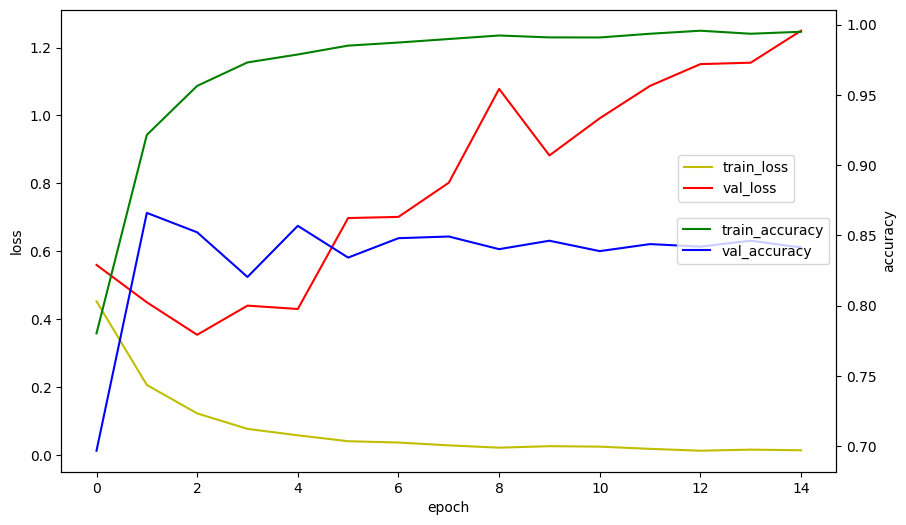

In [44]:
# 5. 모델 평가
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['acc'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_acc'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

# 11. 모델 평가

In [45]:
# 테스트 데이트로 평가
loss,acc = model.evaluate(X_test,y_test)
print('test의 데이터 정확도 :', acc)

782/782 [==============================] - 26s 33ms/step - loss: 8.6742 - acc: 0.4962
test의 데이터 정확도 : 0.49616000056266785


In [46]:
# 모델 저장
model.save('imdb_v2.10_skiplength80.h5')

In [47]:
# 혼동행렬(교차표, 평가성능 지표)
# y_test # 실제값
pred = model.predict(X_test)
y_hat = (pred>0.5).astype(int) # 예측값
y_hat

782/782 [==============================] - 26s 33ms/step


array([[0, 1],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [0, 1],
       [1, 0]])

In [48]:
y_test.shape,y_hat.shape

((25000,), (25000, 2))

In [49]:
# 실제값(1차원)과 예측값(2차원)이 차원이 같지 않아도 됨
confusion_matrix(y_test,y_hat)

ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

In [50]:
# 실제값과 에측값의 차원이 1차원(동일 차원이어야 함)
ctab =pd.crosstab(y_test,y_hat.reshape(-1),rownames=['실제값'],colnames=['예측값'])
ctab['0확률'] = [ctab.loc[0,0]/25000*100,ctab.loc[1,0]/25000*100]
ctab['1확률'] = [ctab.loc[0,1]/25000*100,ctab.loc[1,1]/25000*100]
ctab

ValueError: All arrays must be of the same length

In [178]:
# accuracy, precision, recall,f1_score
print('acc : ',acc)
print('precision : ', precision_score(y_test,y_hat))
print('recall : ',recall_score(y_test,y_hat))
print('f1 score : ', f1_score(y_test,y_hat))

acc :  0.4962399899959564
precision :  0.49602166920602675
recall :  0.4688
f1 score :  0.48202681582627294


# 12. 모델 사용하기

In [172]:
import re
review = """This film is a beautifully crafted piece of work. 
The narrative is compelling from start to finish, and the characters feel incredibly real. 
The cinematography and soundtrack blend perfectly, creating an atmosphere that stays with you long after the movie ends. 
Highly recommended. ^_^ -,- :(
""".lower()
review = re.sub('[^a-zA-Z0-9\s]',' ',review)
review = review.split()
print(review)
encoded = [1] + [word_to_id.get(r, -1)+3 for r in review]
#encoded = [2 if (e<=30) | (e>10000) else e for e in encoded] # skip_top 사용시
print(encoded)

['this', 'film', 'is', 'a', 'beautifully', 'crafted', 'piece', 'of', 'work', 'the', 'narrative', 'is', 'compelling', 'from', 'start', 'to', 'finish', 'and', 'the', 'characters', 'feel', 'incredibly', 'real', 'the', 'cinematography', 'and', 'soundtrack', 'blend', 'perfectly', 'creating', 'an', 'atmosphere', 'that', 'stays', 'with', 'you', 'long', 'after', 'the', 'movie', 'ends', 'highly', 'recommended']
[2, 2, 2, 2, 2, 1293, 2882, 418, 2, 157, 2, 1321, 2, 1444, 39, 380, 2, 1363, 2, 2, 105, 235, 966, 147, 2, 627, 2, 816, 3890, 950, 1855, 35, 841, 2, 2677, 2, 2, 196, 103, 2, 2, 630, 545, 1178]


In [173]:
input_data =pad_sequences([encoded],
                           maxlen=MY_LENGTH,
                           truncating='post', # 80 단어 이상일 경우 어디를 짜를 지 여부
                           #truncating='pre',
                           #padding='post',
                           padding='pre',    # 길 경우, 뒷부분을 짜르고 짧은 경우 뒤에 zero를 붙임
                           )
input_data

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [174]:
# (model.predict(input_data)
(model.predict(input_data).argmax(axis=-1)


1/1 [==============================] - 0s 168ms/step


array([[1]], dtype=int8)

In [175]:
review = """This film is an astonishing masterclass in how not to make a movie. 
The plot wanders aimlessly like it’s desperately searching for a purpose it never finds. 
Characters feel flatter than cardboard cutouts, delivering dialogue so painfully awkward it’s almost impressive. 
The visual effects look unfinished, as if someone clicked “export” halfway through rendering. 
Even the soundtrack seems confused, mismatched with nearly every scene. ^.^
By the time the credits finally roll, the only emotion left is pure relief that it’s over. 
Watching this movie feels less like entertainment and more like a test of patience no one asked to take."""
review = re.sub('[^a-zA-Z0-9\s]',' ',review)
review = review.lower().split()
encoded = [1] + [word_to_id.get(r,-1)+3 for r in review]
encoded = [e if (e>=30) & (e<=10000) else 2  for e in encoded]
print(encoded,len(encoded))

[2, 2, 2, 2, 35, 5149, 2, 2, 89, 2, 2, 97, 2, 2, 2, 114, 5933, 2, 40, 2, 590, 2724, 3165, 2, 2, 1288, 2, 115, 659, 105, 235, 2, 74, 3440, 2, 4498, 414, 38, 2149, 2094, 2, 590, 220, 1159, 2, 1114, 302, 168, 9666, 2, 48, 294, 2, 2, 2807, 143, 7700, 60, 2, 816, 186, 1471, 2, 2, 754, 175, 136, 34, 2, 58, 2, 898, 417, 1686, 2, 64, 1426, 317, 2, 1050, 2143, 2, 2, 590, 120, 149, 2, 2, 764, 329, 40, 722, 2, 53, 40, 2, 2181, 2, 5063, 57, 31, 1803, 2, 193] 104


In [176]:
input_data =pad_sequences([encoded],
                           maxlen=MY_LENGTH,
                           truncating='post', # 80 단어 이상일 경우 어디를 짜를 지 여부
                           #truncating='pre',
                           #padding='post',
                           padding='pre',    # 길 경우, 뒷부분을 짜르고 짧은 경우 뒤에 zero를 붙임
                           )
input_data

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    2,    2,    2,
           2,   35, 5149,    2,    2,   89,    2,    2,   97,    2,    2,
           2,  114, 5933,    2,   40,    2,  590, 2724, 3165,    2,    2,
        1288,    2,  115,  659,  105,  235,    2,   74, 3440,    2, 4498,
         414,   38, 2149, 2094,    2,  590,  220, 1159,    2, 1114,  302,
         168, 9666,    2,   48,  294, 

In [177]:
(model.predict(input_data) > 0.5).astype('int8')

1/1 [==============================] - 0s 23ms/step


array([[0]], dtype=int8)